## Please insert some parameters
* the name of the source 

In [1]:
source = 'Cen X-3'


### Imports

In [2]:
import hratio
import numpy as np
from astropy.table import Table
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.stats import norm
import shutil
import os, sys
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord
from importlib import reload
from astropy.io import fits as pf

## Importing modules developed for this project:
* nustarpipeline process to wrap the nustar analysis for our needs
* nustarpipeline utils to collect useful functions
* pyxmmsas (originally for XMM) for spectral fitting


In [3]:
os.environ['HEADAS']='/opt/heasoft/x86_64-pc-linux-gnu-libc2.31'
os.system('. ${HEADAS}/headas-init.sh')
os.system('export PFILES="/tmp$$.tmp/pfiles;$HEADAS/syspfiles"')

0

In [4]:
from nustarpipeline import process, utils
import pyxmmsas as pysas

## This is the spectral analysis.
* First find a suitable model for your source, running xspec iteratively and save the model only, use the file as input mod_file below
* the routine below provides a file files.xcm to start with a basic model called mod_base.xcm
* compute the MCMC to get eror and corner plots
* at a second iteration, you can just load the chain (comment and uncomment the lines starting with load_chain=...)
* the chain commands are to create a script to be lunched externally and need to be tuned for the correct parameter number

### load spectra and and a basic model in pyxspec

In [5]:
help(pysas.epic_xspec_mcmc_fit)

Help on function epic_xspec_mcmc_fit in module pyxmmsas:

epic_xspec_mcmc_fit(xspec, model_name, pn_spec='PNsource_spectrum_rbn.pi', mos1_spec='MOS1source_spectrum_rbn.pi', mos2_spec='MOS2source_spectrum_rbn.pi', ignore_string=['**-0.5,10.0-**', '**-0.5,10.0-**', '**-0.5,10.0-**'], outputfiles_basename='gw-mcmc-', load_chain=False, perform_fit=True, set_priors=False, jeffreys_priors=['norm'], gauss_priors=[], gauss_prior_parameters=(0.0, 1.0), burn=6000, runLength=26000, walkers=20, save_xcm=True, compute_errors=True, run_chain=True, statistics='cstat', plt_type='euf del', reset_constants=True)
    :param xspec: an xspec instance
    :param model_name: name of the model
    :param pn_spec: first spectrum
    :param mos1_spec: second spectrum (if 'none' skips)
    :param mos2_spec: third spectrum (if 'none' skips)
    :param ignore_string: a list of xspec ignore strings, one per each spectrum, e.g. ['**-0.5,10.0-**', '**-0.5,10.0-**', '**-0.5,10.0-**']
    :param outputfiles_basename: t

Using output file basename GW-mod_base-
We load 2 spectra
['**-3.0,70.0-**', '**-3.0,70.0-**']
   All chains are now removed.

*** Background file has inconsistent format with data:  background file FPMA_bk.pha read skipped

*** Background file has inconsistent format with data:  background file FPMB_bk.pha read skipped

2 spectra  in use
 
Spectral Data File: FPMA_sr_rbn.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.473e+01 +/- 5.496e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-2440
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 2.143e+04 sec
 Using fit statistic: cstat
 Using Response (RMF) File            FPMA_sr.rmf for Source 1
 Using Auxiliary Response (ARF) File  FPMA_sr.arf

Spectral Data File: FPMB_sr_rbn.pi  Spectrum 2
Net count rate (cts/s) for Spectrum:2  6.076e+01 +/- 5.306e-02
 Assigned to Data Group 2 and Plot Group 2
  Noticed Channels:  1-2442
  Telescope: NuSTAR Instrument: FPMB  Channel Type: PI
  Exposure T

*** Check for missing or improperly set HDUCLASS keywords in HDU of spectrum file
    (or PHAVERSN keyword for old-style files).
*** Check for missing or improperly set HDUCLASS keywords in HDU of spectrum file
    (or PHAVERSN keyword for old-style files).
PGPLOT /png: writing new file as GW-mod_base-euf_plot.png_2


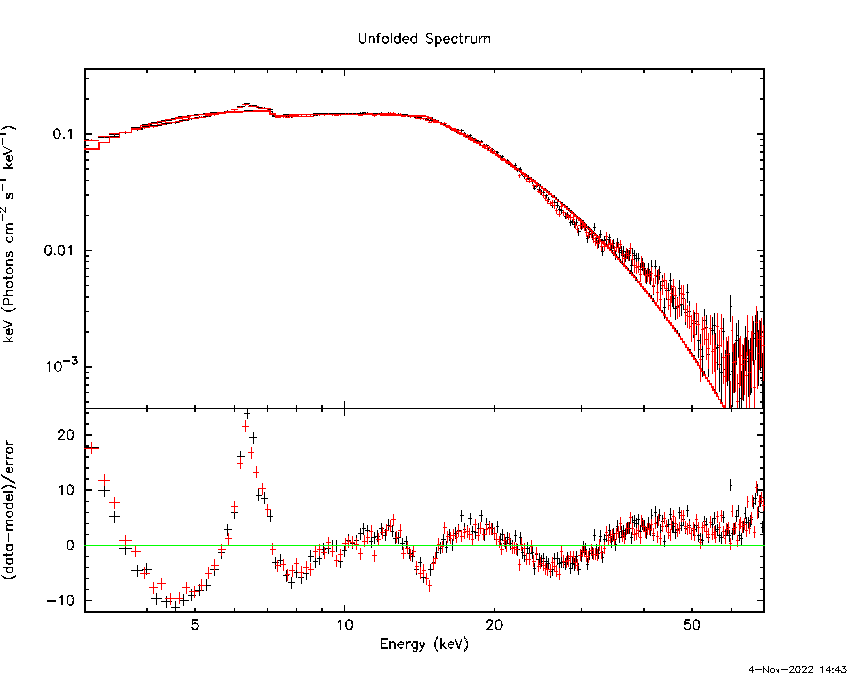

 C-Statistic                 3873.51     using 220 bins.
Total fit statistic                          8093.72     with 431 d.o.f.
   (Includes a Bayesian contribution of 4.92)

Test statistic : Chi-Squared                 7277.51     using 437 bins.
 Null hypothesis probability of 0.00e+00 with 431 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                 4210.37     using 217 bins.
                 C-Statistic                 3873.51     using 220 bins.
Total fit statistic                          8104.44     with 431 d.o.f.
   (Includes a Bayesian contribution of 10.28)

Test statistic : Chi-Squared                 7277.51     using 437 bins.
 Null hypothesis probability of 0.00e+00 with 431 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                 4210.37     using 217 bins.
                 C-Statistic                 3873.51     using 220 bins.
Total fit statistic                          8112.

In [129]:
import xspec
os.chdir('/home/jovyan/work/ap-lab-i-2022/data/')

#use the base model
mod_file = 'mod_base.xcm'

#The following is an attempt to plot the model without the cyclotron lines
#mod_file = 'mod_3gabs_zero.xcm'



outputfiles_basename = 'GW-%s-' % (mod_file.replace('../mod_', '').replace('.xcm',''))

#'bxa-run-model.xcm'
pn_spec="FPMA_sr_rbn.pi"
mos1_spec="FPMB_sr_rbn.pi"
mos2_spec="none"
ignore_string=['**-3.0,70.0-**']*2
print("Using output file basename " + outputfiles_basename)


load_chain=False
compute_errors=False
perform_fit=False
save_xcm=False
run_chain=False

chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = pn_spec,
                                mos1_spec = mos1_spec,
                                mos2_spec =mos2_spec, 
                                jeffreys_priors=['norm', 'nH', 'cutoffE', 'foldE'],
                                               #jeffreys_priors=['norm', 'nH', 'T0', 'kT', 'taup'],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=perform_fit, set_priors=True, walkers=60, 
                                               run_chain=run_chain,
                                               compute_errors=compute_errors, save_xcm=save_xcm )


## We make a fit with a more complex model

Using output file basename GW-mod_pcfabs_2gauss_2gabs-
   All chains are now removed.
We load 2 spectra
['**-3.0,70.0-**', '**-3.0,70.0-**']


*** Check for missing or improperly set HDUCLASS keywords in HDU of spectrum file
    (or PHAVERSN keyword for old-style files).
*** Check for missing or improperly set HDUCLASS keywords in HDU of spectrum file
    (or PHAVERSN keyword for old-style files).



*** Background file has inconsistent format with data:  background file FPMA_bk.pha read skipped

*** Background file has inconsistent format with data:  background file FPMB_bk.pha read skipped

2 spectra  in use
 
Spectral Data File: FPMA_sr_rbn.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.473e+01 +/- 5.496e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-2440
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 2.143e+04 sec
 Using fit statistic: cstat
 Using Response (RMF) File            FPMA_sr.rmf for Source 1
 Using Auxiliary Response (ARF) File  FPMA_sr.arf

Spectral Data File: FPMB_sr_rbn.pi  Spectrum 2
Net count rate (cts/s) for Spectrum:2  6.076e+01 +/- 5.306e-02
 Assigned to Data Group 2 and Plot Group 2
  Noticed Channels:  1-2442
  Telescope: NuSTAR Instrument: FPMB  Channel Type: PI
  Exposure Time: 2.158e+04 sec
 Using fit statistic: cstat
 Using Response (RMF) File            FPMB_sr.rmf for Source 1
 Using Auxiliary

PGPLOT /png: writing new file as GW-mod_pcfabs_2gauss_2gabs-euf_plot.png_2


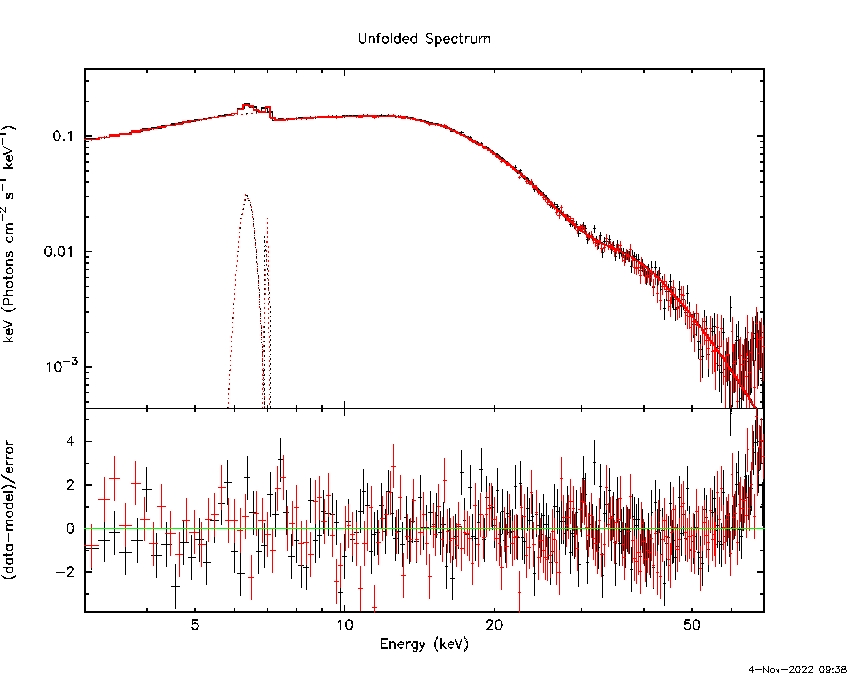

                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH          2:nH    3:CvrFract       4:LineE       5:Sigma    6:Strength       7:LineE       8:Sigma    9:Strength    10:cutoffE      11:foldE      12:LineE      13:Sigma       14:norm       20:norm   21:PhoIndex       24:norm       48:norm
Fit Stat= 660.4516823824962 Chi2= 569.193763496547 dof= 419

Spectral parameters:

	nH__01 3 10^22 (2-3)
	nH__02 40 10^22 (38-43)
	CvrFract__03 0.5  (0.5-0.6)
	LineE__04 30 keV (30-30)
	Sigma__05 5 keV (5-6)
	Strength__06 7  (6-7)
	LineE__07 15 keV (14-15)
	Sigma__08 0.7 keV (0.6-0.7)
	Strength__09 0.12  (0.11-0.14)
	cutoffE__10 14 keV (14-14)
	foldE__11 10 keV (10-10)
	LineE__12 6 keV (6-6)
	Sigma__13 0.18 keV (0.16-0.20)
	norm__14 3e-03  (3e-03-3e-03)
	LineE 7 keV 
	Sigma 0.00 keV 
	norm 0.00  
	LineE 7 keV 
	Sigma 0.03 keV 
	norm__20 6e-04  (5e-04-6e-04)
	PhoIndex__21 1  (1-1)
	eMin 3 keV 
	eMax 70 keV 
	norm__24 1.4e+04  (1.4e+04-1.4e+04)
	nH 3 10^22 
	nH 40 10

In [12]:
import xspec

run_chain = True
reload(pysas)
fit_by_bin={}

chains=[]
#mod_file=outputfiles_basename+'model.xcm'
#mod_file='../model_cut.xcm'
    
mod_file = 'mod_pcfabs_2gauss_2gabs.xcm'


outputfiles_basename = 'GW-%s-' % (mod_file.replace('../mod_', '').replace('.xcm',''))

#'bxa-run-model.xcm'
pn_spec="FPMA_sr_rbn.pi"
mos1_spec="FPMB_sr_rbn.pi"
mos2_spec="none"
ignore_string=['**-3.0,70.0-**']*2
print("Using output file basename " + outputfiles_basename)


if run_chain:
    load_chain=False
    compute_errors=True
    perform_fit=True
    save_xcm=True
else:
    load_chain=True
    compute_errors=True
    perform_fit=False
    save_xcm=False
    
    
chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = pn_spec,
                                mos1_spec = mos1_spec,
                                mos2_spec =mos2_spec, 
                                jeffreys_priors=['norm', 'nH', 'cutoffE', 'foldE'],
                                               #jeffreys_priors=['norm', 'nH', 'T0', 'kT', 'taup'],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=perform_fit, set_priors=True, walkers=60, 
                                               run_chain=run_chain,
                                               compute_errors=compute_errors, save_xcm=save_xcm, 
                                               burn=8000, runLength=64000, )
chains.append(chain_name)


chain_commands='''

chain clear
chain type gw
chain walkers 60
chain burn 26000
chain length 36000

bayes on
bayes 1 jeffreys
bayes 8 jeffreys
bayes 9 jeffreys
bayes 12 jeffreys
bayes 16 jeffreys
bayes 32 jeffreys
query yes
fit

chain proposal gaussian diagonal 1e-1 1e-5 0.2 0.5 0.1 10. 10.
chain run %schain.fits

quit
yes

'''%outputfiles_basename


exposure, tstart, tstop = pysas.get_spec_exp_times("FPMA_sr_rbn.pi")



#    break



In [86]:
with open("FPMA_sr_rbn.pi", mode='rb') as file:
    fileContent = file.read()
print(len(fileContent))

169920


In [119]:
#print(xspec.AllData(1))
#help(xspec.AllData)
print(len(xspec.AllData(1).noticed), len(xspec.AllData(2).noticed))
print(len(xspec.AllModels, len(xspec.AllData(2).noticed))



217 220


In [144]:
xspec.AllModels(1).

 Additive Models: 
      agauss     c6vmekl    eplogpar       mekal       redge     vpshock
      agnsed     carbatm      eqpair     mkcflow      refsch    vraymond
     agnslim      cemekl     eqtherm         nei        rnei       vrnei
        apec      cevmkl       equil      nlapec       sedov      vsedov
       bapec       cflow      expdec     npshock        sirf      vtapec
       bbody      compLS    ezdiskbb         nsa      slimbh      vvapec
    bbodyrad      compPS       gadem     nsagrav       smaug      vvgnei
      bexrav      compST    gaussian     nsatmos      snapec       vvnei
      bexriv      compTT        gnei       nsmax       srcut   vvnpshock
     bkn2pow      compbb        grad      nsmaxg       sresc    vvpshock
    bknpower     compmag     grbcomp         nsx         ssa      vvrnei
         bmc   compmag2*     grbcut*       nteea        step     vvsedov
      bremss      comptb      grbjet     nthComp       tapec     vvtapec
       brnei      compth        

In [94]:
final_chi2 = xspec.Fit.testStatistic
#For the BIC we need the Chi-squared, k the number of model paramaters and n the number of data points
k = len(fit_res)
n = 1311438 + 1387011
final_BIC = final_chi2 + k*np.log(n)
print(final_chi2, final_BIC)

569.193763496547 880.1657056474945


## This estimated the goodness of fit (it is long)

In [ ]:
if True:
   
    sorted_sampled_fit_statistics, best_fit_statistic, goodness = \
    pysas.goodness_from_chain(xspec, outputfiles_basename, n_sample=1000,
                            pn_spec=pn_spec,
                            mos1_spec=mos1_spec,
                            mos2_spec=mos2_spec,
                            ignore_string=ignore_string)
    ff=open(outputfiles_basename+'simul_test.txt','w')
    for x in sorted_sampled_fit_statistics:
        ff.write("%f\n" % x)
    ff.write("%f*\n" % best_fit_statistic)
    ff.close()
    os.chdir('..')
    plt.figure()
    plt.hist(sorted_sampled_fit_statistics, bins=20, label='Sample')
    plt.axvline(best_fit_statistic, color='red', label='Best fit')
    plt.xlabel('Test statistics')
    plt.ylabel('Simulations')
    plt.legend()
    

## Please edit the next cell to display parameters of your model

In [86]:
latex_label_dict=pysas.default_latex_label_dict.copy()
print(latex_label_dict)
E_i=0
S_i=0
for j in fit_res.keys():
    if j=='rate':
        latex_label_dict.update({j:'Cts/s'})
    if j=='cstat':
        latex_label_dict.update({j:'$\chi^2_\\mathrm{red}$/d.o.f.'})
    if j=='nH
    if j[:4]=='LineE':
        if E_i==0:
            latex_label_dict.update({j:'$\E_\\mathrm{Fe}$'})
            E_i+=1
        elif E_i<=2:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc1}$'})
            E_i+=1
        elif 2<E_i<=4:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc2}$'})
            E_i+=1
        else:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc3}$'})
            E_i+=1
    if j[:4]=='Sigma':
        if S_i==0:
            latex_label_dict.update({j:'$\E_\\mathrm{Fe}$'})
            S_i+=1
        elif S_i<=2:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc1}$'})
            S_i+=1
        elif 2<S_i<=4:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc2}$'})
            S_i+=1
        else:
            latex_label_dict.update({j:'$\E_\\mathrm{Cyc3}$'})
            S_i+=1
            
                        
            
    


{'nH__02': '$n_\\mathrm{H}$', 'nH__03': '$n_\\mathrm{H, pc}$', 'CvrFract__04': 'Cov. Frac.', 'PhoIndex__05': '$\\Gamma$', 'norm__08': 'Flux (1-10 keV)', 'nH__2': '$n_\\mathrm{H}$', 'nH__3': '$n_\\mathrm{H, pc}$', 'CvrFract__4': 'Cov. Frac.', 'PhoIndex__5': '$\\Gamma$', 'norm__8': 'Flux (1-10 keV)', 'log(nH)__2': '$\\log(n_\\mathrm{H})$', 'log(nH)__3': '$\\log(n_\\mathrm{H, pc})$', 'log(norm)__8': '$\\log$(Flux (1-10 keV))', 'rate': 'Count Rate'}
rate
cstat
plot_filename
nH__01
nH__02
CvrFract__03
LineE__04
Sigma__05
Strength__06
LineE__07
Sigma__08
Strength__09
cutoffE__10
foldE__11
LineE__12
Sigma__13
norm__14
norm__20
PhoIndex__21
norm__24
norm__48


In [85]:
import pyxmmsas as pysas
latex_label_dict=pysas.default_latex_label_dict.copy()
latex_label_dict.update({ 
                        'nH__01': '$N_\\mathrm{H}$',
                        'nH__1': '$N_\\mathrm{H}$',                        
    'rate' : 'Cts/s',
    'cstat': '$\chi^2_\\mathrm{red}$/d.o.f.',
    
    'LineE__15': '$E_\\mathrm{Fe}$',
    'Sigma__16': '$\sigma_\\mathrm{Fe}$',
    'norm__17': '$N_\\mathrm{Fe}$',
    
    'LineE__2' : '$E_\\mathrm{Cyc1}$',
    'LineE__02' : '$E_\\mathrm{Cyc1}$',
    'Sigma__3' : '$\sigma_\\mathrm{Cyc1}$',
    'Sigma__03' : '$\sigma_\\mathrm{Cyc1}$',
    'Strength__4' : '$\\tau_\\mathrm{Cyc1}$',
    'Strength__04' : '$\\tau_\\mathrm{Cyc1}$',
    
    'LineE__5' : '$E_\\mathrm{Cyc2}$',
    'LineE__05' : '$E_\\mathrm{Cyc2}$',
    'Sigma__6' : '$\sigma_\\mathrm{Cyc2}$',
    'Sigma__06' : '$\sigma_\\mathrm{Cyc2}$',
    'Strength__7' : '$\\tau_\\mathrm{Cyc2}$',
    'Strength__07' : '$\\tau_\\mathrm{Cyc2}$',
    
    'LineE__8' : '$E_\\mathrm{Cyc3}$',
    'LineE__08' : '$E_\\mathrm{Cyc3}$',
    'Sigma__9' : '$\sigma_\\mathrm{Cyc3}$',
    'Sigma__09' : '$\sigma_\\mathrm{Cyc3}$',
    'Strength__10' : '$\\tau_\\mathrm{Cyc3}$',
    
    'cutoffE__11': '$E_\\mathrm{C}$',
    'foldE__12': '$E_\\mathrm{F}$',
    'kT__13': '$kT_\\mathrm{BB}$',
    'norm__14' : '$r^2_\\mathrm{BB}$',
        
     'norm__21': 'F [$10^{-12}$cgs]', #$_\mathrm{2-10 keV}$
    'norm__42': 'Flux (3-20 keV)',
    'PhoIndex__18': '$\\Gamma$',
})

In [116]:
import pyxmmsas as pysas
latex_label_dict=pysas.default_latex_label_dict.copy()
latex_label_dict.update({ 
    'nH__01': '$N_\\mathrm{H}$',
    'nH__02': '$N_\\mathrm{H}$',
    
    'CvrFract__03': 'Cov. Frac.', 
    
    'rate' : 'Cts/s',
    'cstat': '$\chi^2_\\mathrm{red}$/d.o.f.',
    
    'LineE__04': '$E_\\mathrm{Cyc1}$',
    'Sigma__05' : '$\sigma_\\mathrm{Cyc1}$',
    'Strength__06' : '$\\tau_\\mathrm{Cyc1}$',
    
    'LineE__07' : '$E_\\mathrm{Cyc2}$',
    'Sigma__08' : '$\sigma_\\mathrm{Cyc2}$',
    'Strength__09' : '$\\tau_\\mathrm{Cyc2}$',
    
    'cutoffE__10': '$E_\\mathrm{C}$',
    'foldE__11': '$E_\\mathrm{F}$',
    'LineE__12' : '$E_\\mathrm{Cyc3}$',
    'Sigma__13' : '$\sigma_\\mathrm{Cyc3}$',

    'PhoIndex__21': '$\\Gamma$',
    'norm__14' : 'F [$10^{-12}$cgs]',
    'norm__20' : 'F [$10^{-12}$cgs]',
    'norm__24' : 'F [$10^{-12}$cgs]', 
    'norm__48': 'Flux (3-20 keV)',
})

In [117]:
print(latex_label_dict.keys())

dict_keys(['nH__02', 'nH__03', 'CvrFract__04', 'PhoIndex__05', 'norm__08', 'nH__2', 'nH__3', 'CvrFract__4', 'PhoIndex__5', 'norm__8', 'log(nH)__2', 'log(nH)__3', 'log(norm)__8', 'rate', 'nH__01', 'nH__1', 'CvrFract__03', 'CvrFract__3', 'cstat', 'LineE__04', 'Sigma__05', 'Strength__06', 'LineE__07', 'Sigma__08', 'Strength__09', 'cutoffE__10', 'foldE__11', 'LineE__12', 'Sigma__13', 'PhoIndex__21', 'norm__14', 'norm__20', 'norm__24', 'norm__48'])


## Dump the latex table of parameters (you will need to make adjustements for the paper)

In [118]:
fit_res

{'rate': [63.24017059584069, 63.18577773099951, 63.294563460681864],
 'cstat': [527.2616630390102, 419],
 'plot_filename': 'GW-mod_pcfabs_2gauss_2gabs-euf_plot.png',
 'nH__01': [2.2859331441703077, 1.343359834868766, 2.9236320681396957],
 'nH__02': [38.47239971519482, 35.533964722319915, 40.629209227551435],
 'CvrFract__03': [0.5564153619314592, 0.5314562181467496, 0.5891385521602361],
 'LineE__04': [29.06508423268699, 28.920801706900736, 29.26213924282802],
 'Sigma__05': [4.533255612250673, 4.403806836327542, 4.74069039422106],
 'Strength__06': [4.726037238091836, 4.510651520194678, 5.045727742856681],
 'LineE__07': [14.500232926942275, 14.437604520145133, 14.56844437965998],
 'Sigma__08': [0.6776270194390341, 0.6289519237139578, 0.7473010590735512],
 'Strength__09': [0.13346369108792744,
  0.12361480228614045,
  0.14792903300743693],
 'cutoffE__10': [14.42376343011276, 14.377796578590901, 14.47392277857216],
 'foldE__11': [9.188211802251471, 9.103995452001426, 9.264908380034562],
 'L

In [119]:
latex_table = pysas.dump_latex_table({'aal': fit_res}, latex_label_dict=latex_label_dict, 
                                        to_skip=['plot_filename','norm__18', 'norm__20', 'times', 'rate', 'nH__1'])
print(latex_table)


\begin{tabular}{lr@{}ll}

\hline

\hline
\multicolumn{4}{c}{aal}\\
\hline
$\chi^2_\mathrm{red}$/d.o.f. &  1.3 &/419 & \\
$N_\mathrm{H}$ & 2.3 &$_{-0.9}^{+0.6}$ & cm$^{-2}$ \\
$N_\mathrm{H}$ & 38 &$_{-3}^{+2}$ & cm$^{-2}$ \\
Cov. Frac. & 0.56 &$_{-0.02}^{+0.03}$ &  \\
$E_\mathrm{Cyc1}$ & 29.07 &$_{-0.14}^{+0.20}$ & keV \\
$\sigma_\mathrm{Cyc1}$ & 4.53 &$_{-0.13}^{+0.21}$ &  \\
$\tau_\mathrm{Cyc1}$ & 4.7 &$_{-0.2}^{+0.3}$ &  \\
$E_\mathrm{Cyc2}$ & 14.50 &$\pm$0.07 & keV\\
$\sigma_\mathrm{Cyc2}$ & 0.68 &$_{-0.05}^{+0.07}$ &  \\
$\tau_\mathrm{Cyc2}$ & 0.133 &$_{-0.010}^{+0.014}$ &  \\
$E_\mathrm{C}$ & 14.42 &$\pm$0.05 & keV\\
$E_\mathrm{F}$ & 9.19 &$\pm$0.08 & keV\\
$E_\mathrm{Cyc3}$ & 6.356 &$\pm$0.008 & keV\\
$\sigma_\mathrm{Cyc3}$ & 0.187 &$_{-0.013}^{+0.020}$ &  \\
F [$10^{-12}$cgs] & 3.12e-03 &$_{-1.19e-04}^{+1.97e-04}$ &  \\
$\Gamma$ & 1.311 &$_{-0.023}^{+0.015}$ &  \\
F [$10^{-12}$cgs] & 1.374e+04 &$_{-9.585e+01}^{+1.517e+02}$ &  \\
Flux (3-20 keV) & 1.365e+04 &$_{-9.733e+01}^{+1.5

## Plot the chain and the corner plot

In [132]:
#reload(pysas)
%matplotlib notebook
import matplotlib.pyplot as plt
from astropy.table import Table
import corner
import xspec
from glob import glob
from matplotlib import rc
#fit_by_bin = {}

plot_chains=True
plot_corners=True

#Find the proper file
chains=sorted(glob('GW-mod_pcfabs_2gauss_2gabs-chain.fits'))
#print(chains)
print(chain_name.replace('.fits',''))

#chains=sorted(glob('GW-pcfabs-chain.fits'))
rc('text', usetex=False)

for i,chain_name in enumerate(chains):

    if i > 5:
        continue
    
    print(chain_name)
    
    table_chain=Table.read(chain_name)
    chain_df=table_chain.to_pandas()
    if plot_chains:
        for kk in table_chain.keys():
            if kk != 'FIT_STATISTIC':
                continue
            ff=plt.figure()
            plt.plot(table_chain[kk], 'o')
            plt.savefig('test_plot.pdf')
            ax=ff.gca()
            ax.set_ylabel(kk)
    
    
    chain_par_names=table_chain.keys()
    
    to_drop=['FIT_STATISTIC', 'nH__1', 'CvrFract__3', 'LineE__4', 'Sigma__5', 'Strength__6',
            'LineE__7', 'Sigma__8', 'Strength__9']
    
    for kk in chain_par_names:
        if 'factor' in kk:
            to_drop.append(kk)
    
    for kk in to_drop:
        chain_df.drop(kk, 1,  inplace=True)
    
    labels=[latex_label_dict[kk] for kk in list(chain_df.columns) ]
    
    rc('text', usetex=False)
    if plot_corners:
        corner_plot=corner.corner(chain_df, bins=20, labels=labels, quantiles=[0.16,0.84],
                                  plot_datapoints=False)
        corner_plot.savefig(chain_name.replace('.fits','')+'_corner_%02d.pdf'%(i+1))
    rc('text', usetex=False)
    
    
    quantiles=chain_df.quantile([0.16,0.5,0.84],axis=0)
    print(quantiles)
    if i>3:
        break


GW-mod_pcfabs_2gauss_2gabs-chain
GW-mod_pcfabs_2gauss_2gabs-chain.fits
 WARNING - UnitsWarning: 'C-Statistic' did not parse as fits unit: Invalid character at col 1 If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html


<IPython.core.display.Javascript object>

/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.drop(kk, 1,  inplace=True)
/tmp/ipykernel_28/298910399.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  chain_df.dr

<IPython.core.display.Javascript object>

          nH__2  cutoffE__10  foldE__11  LineE__12  Sigma__13  norm__14  \
0.16  35.551095    14.378031   9.104513   6.348236   0.173872  0.003003   
0.50  38.170952    14.423213   9.183656   6.356453   0.190324  0.003153   
0.84  40.608264    14.473751   9.264591   6.364212   0.206455  0.003318   

      norm__20  PhoIndex__21      norm__24      norm__48  
0.16  0.000524      1.288159  13640.861406  13551.160854  
0.50  0.000580      1.307790  13754.744994  13669.187943  
0.84  0.000636      1.326757  13887.006404  13799.460727  


## Here we test another model...

In [105]:
xspec.AllModels.lmod("bwmod", "/home/jovyan/work/ap-lab-i-2022/xspec_lmod/")

Model package bwmod successfully loaded.


In [101]:
import xspec

run_chain = True
reload(pysas)
fit_by_bin={}

chains=[]
#mod_file=outputfiles_basename+'model.xcm'
#mod_file='../model_cut.xcm'
    
mod_file = 'mod_newhcut_4gaus_1gabs.xcm'


outputfiles_basename = 'GW-%s-' % (mod_file.replace('../mod_', '').replace('.xcm',''))

#'bxa-run-model.xcm'
pn_spec="FPMA_sr_rbn.pi"
mos1_spec="FPMB_sr_rbn.pi"
mos2_spec="none"
ignore_string=['**-3.0,70.0-**']*2
print("Using output file basename " + outputfiles_basename)


if run_chain:
    load_chain=False
    compute_errors=True
    perform_fit=True
    save_xcm=True
else:
    load_chain=True
    compute_errors=True
    perform_fit=False
    save_xcm=False
    
    
chain_name, fit_res =pysas.epic_xspec_mcmc_fit(xspec, mod_file, 
                                outputfiles_basename = outputfiles_basename,
                                pn_spec = pn_spec,
                                mos1_spec = mos1_spec,
                                mos2_spec =mos2_spec, 
                                jeffreys_priors=['norm', 'nH', 'cutoffE', 'foldE'],
                                               #jeffreys_priors=['norm', 'nH', 'T0', 'kT', 'taup'],
                                ignore_string=ignore_string,
                                load_chain=load_chain, perform_fit=perform_fit, set_priors=True, walkers=60, 
                                               run_chain=run_chain,
                                               compute_errors=compute_errors, save_xcm=save_xcm, 
                                               burn=8000, runLength=64000, )
chains.append(chain_name)


chain_commands='''

chain clear
chain type gw
chain walkers 60
chain burn 26000
chain length 36000

bayes on
bayes 1 jeffreys
bayes 8 jeffreys
bayes 9 jeffreys
bayes 12 jeffreys
bayes 16 jeffreys
bayes 32 jeffreys
query yes
fit

chain proposal gaussian diagonal 1e-1 1e-5 0.2 0.5 0.1 10. 10.
chain run %schain.fits

quit
yes

'''%outputfiles_basename


exposure, tstart, tstop = pysas.get_spec_exp_times("FPMA_sr_rbn.pi")



#break

Using output file basename GW-mod_newhcut_4gaus_1gabs-
We load 2 spectra
['**-3.0,70.0-**', '**-3.0,70.0-**']
   All chains are now removed.

***Warning: The file sent to Xset.restore(): mod_newhcut_4gaus_1gabs.xcm
    is not detected to be a file generated from Xset.save().
    Xset.restore() usage is only intended for Xset.save() output.
    General XSPEC/Tcl scripts may not fully execute in PyXspec.



*** Background file has inconsistent format with data:  background file FPMA_bk.pha read skipped

*** Background file has inconsistent format with data:  background file FPMB_bk.pha read skipped

2 spectra  in use
 
Spectral Data File: FPMA_sr_rbn.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.473e+01 +/- 5.496e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-2440
  Telescope: NuSTAR Instrument: FPMA  Channel Type: PI
  Exposure Time: 2.143e+04 sec
 Using fit statistic: cstat
 Using Response (RMF) File            FPMA_sr.rmf for Source 1
 Using Auxiliary 

*** Check for missing or improperly set HDUCLASS keywords in HDU of spectrum file
    (or PHAVERSN keyword for old-style files).
*** Check for missing or improperly set HDUCLASS keywords in HDU of spectrum file
    (or PHAVERSN keyword for old-style files).

***XSPEC Error:  No model component named newhcut
newhcut is not a valid model component name.
 Additive Models: 
      agauss     c6vmekl      eqpair         nei        rnei    vraymond
      agnsed     carbatm     eqtherm      nlapec       sedov       vrnei
     agnslim      cemekl       equil     npshock        sirf      vsedov
        apec      cevmkl      expdec         nsa      slimbh      vtapec
       bapec       cflow    ezdiskbb     nsagrav       smaug      vvapec
       bbody      compLS       gadem     nsatmos      snapec      vvgnei
    bbodyrad      compPS    gaussian       nsmax       srcut       vvnei
      bexrav      compST        gnei      nsmaxg       sresc   vvnpshock
      bexriv      compTT        grad       

Exception: Error executing command: model